TITLE: CNN TEXT CLASSIFICATION

Objective: To build and evaluate a CNN-based text classifier on a real-world dataset by preprocessing text, representing words through embeddings, extracting features with convolution and pooling layers, and performing classification using fully connected layers. The model’s effectiveness will be measured using accuracy, precision, recall, and F1-score.

In [1]:
#  Import libraries
import numpy as np
import pandas as pd
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
# LOAD THE DATASET FROM DRIVE
from google.colab import files

# This will prompt you to upload the file from your local machine
uploaded = files.upload()

Saving IMDB REVIEW.zip to IMDB REVIEW (1).zip


In [3]:
import zipfile
import os

with zipfile.ZipFile("IMDB REVIEW.zip", "r") as zip_ref:
    zip_ref.extractall("/content/")

# Check what got extracted
os.listdir("/content")

['.config',
 'IMDB REVIEW (1).zip',
 'IMDB Dataset.csv',
 'IMDB REVIEW.zip',
 'sample_data']

In [4]:
import pandas as pd

df = pd.read_csv("IMDB Dataset.csv")
print(df.shape)

(50000, 2)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [6]:
print(df.head())
print(df['sentiment'].value_counts())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


In [7]:
# Clean text function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)  # remove HTML tags
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

df['review'] = df['review'].apply(clean_text)

In [8]:
train_reviews, test_reviews, y_train, y_test = train_test_split(
    df['review'].tolist(),
    df['sentiment'].tolist(),
    test_size=0.2,
    random_state=42
)


LABEL ENCODE

In [9]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)  # positive->1, negative->0
y_test = le.transform(y_test)


In [10]:
MAX_NUM_WORDS = 20000
MAX_SEQUENCE_LENGTH = 1000

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(train_reviews)

train_sequences = tokenizer.texts_to_sequences(train_reviews)
test_sequences = tokenizer.texts_to_sequences(test_reviews)

X_train = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_test = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

VOCAB_SIZE = MAX_NUM_WORDS


DEFINE MODEL

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, SpatialDropout1D

EMBED_SIZE = 300
MAX_SEQUENCE_LENGTH = 1000
VOCAB_SIZE = 20000  # should match tokenizer.num_words or your max words

model = Sequential([
    Input(shape=(MAX_SEQUENCE_LENGTH,)),
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH),
    SpatialDropout1D(0.4),           # drop entire embedding channels randomly
    Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=16, kernel_size=4, padding='same', activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),     # smaller dense layer to reduce overfitting
    Dropout(0.6),                     # higher dropout
    Dense(1, activation='sigmoid')    # binary output
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()



/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 1000, 300)      │     6,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 1000, 300)      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 1000, 64)       │        76,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 500, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 500, 32)        │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 250, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 250, 16)        │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 125, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       128,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,215,281 (23.71 MB)

 Trainable params: 6,215,281 (23.71 MB)

 Non-trainable params: 0 (0.00 B)

TRAIN MODEL

In [13]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=5,
    batch_size=64,
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 559s 987ms/step - accuracy: 0.6010 - loss: 0.6170 - val_accuracy: 0.8798 - val_loss: 0.2928
Epoch 2/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 546s 970ms/step - accuracy: 0.9184 - loss: 0.2240 - val_accuracy: 0.9028 - val_loss: 0.2361
Epoch 3/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 571s 987ms/step - accuracy: 0.9593 - loss: 0.1257 - val_accuracy: 0.9065 - val_loss: 0.2749
Epoch 4/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 564s 991ms/step - accuracy: 0.9781 - loss: 0.0691 - val_accuracy: 0.8980 - val_loss: 0.3614
Epoch 5/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 560s 987ms/step - accuracy: 0.9884 - loss: 0.0350 - val_accuracy: 0.8985 - val_loss: 0.4435


In [14]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)


313/313 ━━━━━━━━━━━━━━━━━━━━ 36s 114ms/step - accuracy: 0.9075 - loss: 0.2606
Test Accuracy: 0.9071999788284302


In [16]:
# Get predicted probabilities
y_pred_prob = model.predict(X_test)

# Convert probabilities to class labels (0 or 1)
y_pred = (y_pred_prob > 0.5).astype(int)


313/313 ━━━━━━━━━━━━━━━━━━━━ 35s 112ms/step


CLASSIFICATION REPORT

In [17]:
from sklearn.metrics import classification_report, confusion_matrix

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))


Confusion Matrix:
[[4479  482]
 [ 446 4593]]

Classification Report:
              precision    recall  f1-score   support

    Negative       0.91      0.90      0.91      4961
    Positive       0.91      0.91      0.91      5039

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



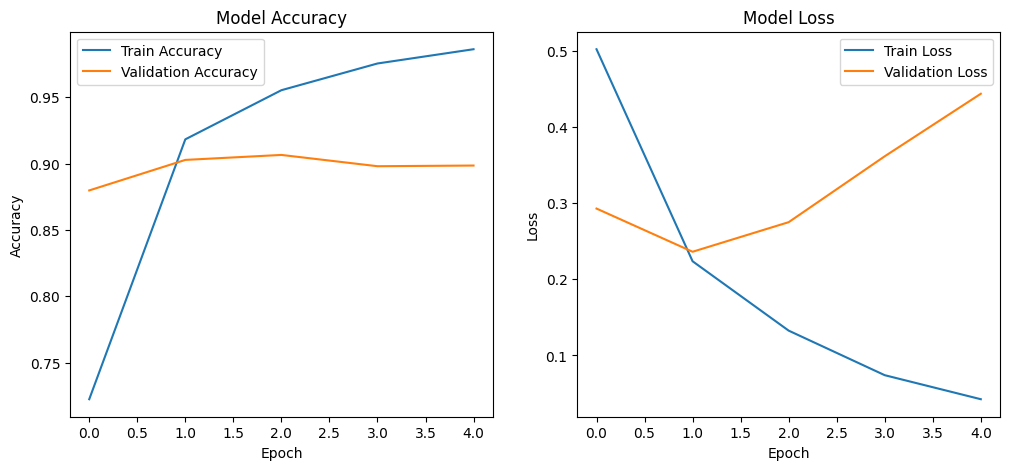

In [18]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


EVALUATE MODEL

In [20]:
# evaluation metrics
# Accuracy
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

acc = accuracy_score(y_test, y_pred)
# Precision
prec = precision_score(y_test, y_pred)
# Recall
rec = recall_score(y_test, y_pred)
# F1-Score
f1 = f1_score(y_test, y_pred)

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-Score:  {f1:.4f}")


Accuracy:  0.9072
Precision: 0.9050
Recall:    0.9115
F1-Score:  0.9082


In [21]:
# confusion mwtrics and classification report
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))



Confusion Matrix:
[[4479  482]
 [ 446 4593]]

Classification Report:
              precision    recall  f1-score   support

    Negative       0.91      0.90      0.91      4961
    Positive       0.91      0.91      0.91      5039

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In [27]:
from sklearn.metrics import precision_recall_fscore_support

# Get predicted probabilities on validation/test set
y_val_prob = model.predict(X_test, verbose=0)

# Try thresholds from 0.1 to 0.9
best_threshold, best_f1 = 0.5, 0
for t in np.arange(0.1, 0.9, 0.01):
    y_val_pred = (y_val_prob >= t).astype(int)
    _, _, f1, _ = precision_recall_fscore_support(y_test, y_val_pred, average='binary')
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print(f"Best threshold: {best_threshold:.2f} with F1-score: {best_f1:.4f}")



Best threshold: 0.51 with F1-score: 0.9084


In [28]:
sample_reviews = [
    "The acting was terrible and the plot made no sense.",
    "I really enjoyed the film, it was one of the best I've seen this year!",
    "The movie was okay, but a bit too long and boring in some parts."
]

for review in sample_reviews:
    predict_review(review, tokenizer, model, max_len=MAX_SEQUENCE_LENGTH, threshold=0.51)



Review: The acting was terrible and the plot made no sense.
Predicted: Negative 😞 (confidence: 0.4264, threshold=0.51)

Review: I really enjoyed the film, it was one of the best I've seen this year!
Predicted: Negative 😞 (confidence: 0.4913, threshold=0.51)

Review: The movie was okay, but a bit too long and boring in some parts.
Predicted: Negative 😞 (confidence: 0.4180, threshold=0.51)


In [29]:
print(test_reviews[0])
predict_review(test_reviews[0], tokenizer, model, max_len=MAX_SEQUENCE_LENGTH, threshold=0.51)


i really liked this summerslam due to the look of the arena the curtains and just the look overall was interesting to me for some reason anyways this could have been one of the best summerslams ever if the wwf didnt have lex luger in the main event against yokozuna now for its time it was ok to have a huge fat man vs a strong man but im glad times have changed it was a terrible main event just like every match luger is in is terrible other matches on the card were razor ramon vs ted dibiase steiner brothers vs heavenly bodies shawn michaels vs curt hening this was the event where shawn named his big monster of a body guard diesel irs vs 123 kid bret hart first takes on doink then takes on jerry lawler and stuff with the harts and lawler was always very interesting then ludvig borga destroyed marty jannetty undertaker took on giant gonzalez in another terrible match the smoking gunns and tatanka took on bam bam bigelow and the headshrinkers and yokozuna defended the world title against 

In [32]:
import re
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

def predict_sentiment_with_rating(text, model, tokenizer, threshold=0.51, maxlen=None):
    # fallback: use global MAX_SEQUENCE_LENGTH if not passed
    if maxlen is None:
        maxlen = MAX_SEQUENCE_LENGTH

    # ---- Step 1: Preprocess text ----
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=maxlen, padding='post', truncating='post')

    # ---- Step 2: Model prediction ----
    prob = model.predict(padded, verbose=0)[0][0]
    label = "Positive 😀" if prob >= threshold else "Negative 😞"

    # ---- Step 3: Check for explicit rating (X/10) ----
    rating_match = re.search(r'(\d{1,2})/10', text)
    if rating_match:
        rating = int(rating_match.group(1))

        # Rule: >=7 → Positive, <=4 → Negative, else Mixed
        if rating >= 7:
            label = "Positive 😀 (rating override)"
            prob = max(prob, 0.8)  # boost confidence
        elif rating <= 4:
            label = "Negative 😞 (rating override)"
            prob = max(prob, 0.8)
        else:
            label = "Mixed 🤔 (rating override)"
            prob = 0.5

    return label, prob



In [33]:
review = """i really liked this summerslam... however it deserves 8/10"""

label, confidence = predict_sentiment_with_rating(review, model, tokenizer, threshold=0.51)
print(f"Predicted: {label} (confidence: {confidence:.4f})")


Predicted: Positive 😀 (rating override) (confidence: 0.9883)
